In [1]:
import pickle
import pandas as pd
from collections import defaultdict
import numpy as np
import datetime

In [2]:
# Load Data
with open('user_songs_all.json', 'rb') as f:
    user_songs = pickle.load(f)
with open('song_users_train.json', 'rb') as f:
    song_users_train = pickle.load(f)
with open('song_users_test.json', 'rb') as f:
    song_users_test = pickle.load(f)
with open('ratings_train_s.json', 'rb') as f:
    ratings_train_s = pickle.load(f)
with open('ratings_test_s.json', 'rb') as f:
    ratings_test_s = pickle.load(f)
with open('user_song_ratings.json', 'rb') as f:
    ratings_all = pickle.load(f)


In [3]:
song_users_train[11]

[55, 38, 57, 58, 59, 60, 62, 63, 64, 978, 27]

In [4]:
song_users_test[11]

[61, 56, 54]

In [5]:
ratings_all[(58,11)]

4.0

In [6]:
def ib_cf(limit):
    K =30
    averages = {} # each user average use
    deviations = defaultdict(list)
    neighboors = defaultdict(list)
    for i in song_users_train.keys():
        users_i = song_users_train[i]
        users_i_set = set(users_i)
        ratings_i = {u: ratings_all[(u, i)] for u in users_i}
        avg_i = np.mean(list(ratings_i.values()))
        dev_i = {u:(r - avg_i) for u, r in ratings_i.items()}
        dev_i_values = np.array(list(dev_i.values()))
        sigma_i = np.sqrt(np.dot(dev_i_values, dev_i_values))
        averages[i] = avg_i
        deviations[i].append(dev_i)
        sl = []
        for j in song_users_train.keys():
            if j!=i:
                users_j = song_users_train[j]
                users_j_set = set(users_j)
                common_users = (users_j_set)&(users_i_set)
                if len(common_users)>= limit:
                    ratings_j = {u:ratings_all[(u,j)] for u in users_j}
                    avg_j = np.mean(list(ratings_j.values()))
                    dev_j = {s:(r - avg_j) for s, r in ratings_j.items()}
                    dev_j_values = np.array(list(dev_j.values()))
                    sigma_j = np.sqrt(np.dot(dev_j_values, dev_j_values))
                    num = sum(dev_i[s]*dev_j[s] for s in common_users)
                    wij = num / (sigma_i*sigma_j+0.0001)
                    sl.append((wij,j))
            else:
                continue
        sl.sort(reverse = True)
        neighboors[i].append(sl[0:K])
    return neighboors,deviations,averages

In [7]:
# LIMIT >= 3

t0 = datetime.datetime.now()
neighboors, deviations, averages = ib_cf(limit=3)
delta_limit4 = datetime.datetime.now()-t0
print("Time to find the neighboors where limit =3:", delta_limit4)

Time to find the neighboors where limit =3: 0:00:10.159146


In [8]:
# LIMIT >= 1

t0 = datetime.datetime.now()
neighboors1, deviations1, averages1 = ib_cf(limit=1)
delta_limit0 = datetime.datetime.now()-t0
print("Time to find the neighboors where limit =1:", delta_limit0)

Time to find the neighboors where limit =0: 0:00:33.631186


In [9]:
neighboors[51]

[[(0.2250379233917503, 626),
  (0.1477923683511897, 483),
  (0.053119366832364734, 736),
  (0.050506096661748816, 418),
  (0.03571275516763569, 726),
  (-0.014007471239676309, 230),
  (-0.016447818405694294, 291)]]

In [10]:
neighboors1[51]

[[(0.44093355326138484, 257),
  (0.43158453903911087, 2060),
  (0.42928881260350565, 87),
  (0.425514001330958, 639),
  (0.4249057931671054, 1033),
  (0.4221606724128223, 1939),
  (0.4183050147609845, 2164),
  (0.4124539572072897, 1837),
  (0.40822329199470014, 1903),
  (0.40822329199470014, 1109),
  (0.4025257433378565, 746),
  (0.3943928192694612, 1809),
  (0.39438032045787147, 1023),
  (0.36001615164734013, 771),
  (0.36001615164734013, 446),
  (0.36001615164734013, 8),
  (0.3593211254103255, 1910),
  (0.3117797842354604, 1134),
  (0.306176843134938, 1137),
  (0.2987937600767109, 1696),
  (0.2974202849912217, 2200),
  (0.2957914896831799, 1727),
  (0.283397467152571, 1031),
  (0.2788741760715967, 1263),
  (0.2700183630122716, 870),
  (0.2639030080161514, 2117),
  (0.2594314917289065, 2110),
  (0.2545833720101831, 497),
  (0.2545750392223655, 1287),
  (0.2545750392223655, 466)]]

In [11]:
# predict function that takes in user 'i' and song 's'
# we use the ratings of the nearest neighboors j to predict the rating of user i
# neighboors might not have been rated the same song: Key Error, 
# deviation for that song doesn't exist
# pass - throw the error
# if the rating is higher than 5 , gives 5, if it is less than 0.5 return 0.5

class predict_error(object):
    def __init__(self,k, neighboors,deviations,averages):
        self.k = k
        self.neighboors = neighboors
        self.deviations = deviations
        self.averages = averages
        
    def predict(self,i,s):
        numerator = 0
        denominator = 0
        for wij,j in self.neighboors[s][0][0:self.k]:
            try: 
                dev = self.deviations[j][0].get(i,0)
                numerator+=wij*dev
                denominator+=abs(wij)
            except KeyError:
                pass
        if denominator == 0:
            prediction = self.averages[s]
        elif denominator == 0 and numerator ==0:
            prediction = self.averages[s]
        else:
            prediction = self.averages[s]+numerator/denominator
        prediction = min(5, prediction)
        prediction = max(0.5, prediction)
        return prediction

    def mse(self, p,t):
        p = np.array(p)
        t = np.array(t)
        return np.mean((p-t)**2)
    
    def mae(self, p,t):
        p = np.array(p)
        t = np.array(t)
        return np.mean(abs(p-t))

    def train_error(self):
        train_predictions, train_targets = [], []
        for (i,s),r in ratings_train_s.items():
            predict_rating= self.predict(i,s)
            train_targets.append(r)
            train_predictions.append(predict_rating)
        mse_train = self.mae(train_predictions, train_targets)
        return mse_train
    
    def test_error(self):
        test_predictions, test_targets = [], []
        for (i,s),r in ratings_test_s.items():
            predict_rating_T= self.predict(i,s)
            test_targets.append(r)
            test_predictions.append(predict_rating_T)
        mse_test = self.mae(test_predictions, test_targets)
        return mse_test    

In [12]:
#LIMIT >= 3, K = 1
t0 = datetime.datetime.now()
class_predict_k1= predict_error(1,neighboors,deviations,averages)
mae1 = class_predict_k1.train_error()
mae_1_test = class_predict_k1.test_error()
delta0_limit5 = datetime.datetime.now()-t0
print("Time to predict where limit >=3 K=1:", delta0_limit5)

Time to predict where limit >=3 K=1: 0:00:00.081745


In [13]:
mae1, mae_1_test

(0.35435567290960984, 0.4775710278014467)

In [14]:
#LIMIT >= 3, K = 3
t0 = datetime.datetime.now()
class_predict_k3= predict_error(3,neighboors,deviations,averages)
mae3 = class_predict_k3.train_error()
mae_3_test = class_predict_k3.test_error()
delta0_limit3 = datetime.datetime.now()-t0
print("Time to predict where limit >=3 K=3:", delta0_limit3)

Time to predict where limit >=3 K=3: 0:00:00.129051


In [15]:
mae3, mae_3_test 

(0.34884393029796545, 0.4740484172677246)

In [16]:
#LIMIT >= 3, K = 5
t0 = datetime.datetime.now()
class_predict_k5= predict_error(5, neighboors,deviations,averages)
mae5 = class_predict_k5.train_error()
mae_5_test = class_predict_k5.test_error()
delta0_limit5 = datetime.datetime.now()-t0
print("Time to predict where limit>=3 K=5:", delta0_limit5)

Time to predict where limit>=3 K=5: 0:00:00.179958


In [17]:
mae5, mae_5_test

(0.34934883996261396, 0.475500514185566)

In [18]:
#LIMIT >=3, K = 7
t0 = datetime.datetime.now()
class_predict_k7= predict_error(7, neighboors,deviations,averages)
mae7 = class_predict_k7.train_error()
mae_7_test = class_predict_k7.test_error()
delta0_limit7 = datetime.datetime.now()-t0
print("Time to predict where limit>=3 K=7:", delta0_limit7)

Time to predict where limit>=3 K=7: 0:00:00.181678


In [19]:
mae7, mae_7_test

(0.3498437978009446, 0.4749503104091296)

In [20]:
#LIMIT >=3, K = 10
t0 = datetime.datetime.now()
class_predict_k10= predict_error(10, neighboors,deviations,averages)
mae10 = class_predict_k10.train_error()
mae_10_test = class_predict_k10.test_error()
delta0_limit10 = datetime.datetime.now()-t0
print("Time to predict where limit >=3 K=10:", delta0_limit10)

Time to predict where limit >=3 K=10: 0:00:00.196258


In [21]:
mae10 , mae_10_test

(0.35049277600685325, 0.4753220453968611)

In [22]:
t0 = datetime.datetime.now()
class_predict_k15= predict_error(15, neighboors,deviations,averages)
mae15 = class_predict_k15.train_error()
mae_15_test = class_predict_k15.test_error()
delta0_limit15 = datetime.datetime.now()-t0
print("Time to predict where limit >=3 K=15:", delta0_limit15)

Time to predict where limit >=3 K=15: 0:00:00.188629


In [23]:
mae15 , mae_15_test

(0.3511580917007956, 0.4755336047371662)

In [24]:
t0 = datetime.datetime.now()
class_predict_k20= predict_error(20, neighboors,deviations,averages)
mae20 = class_predict_k20.train_error()
mae_20_test = class_predict_k20.test_error()
delta0_limit20 = datetime.datetime.now()-t0
print("Time to predict where limit >=3 K=20:", delta0_limit20)

Time to predict where limit >=3 K=20: 0:00:00.155575


In [25]:
mae20 , mae_20_test

(0.3514616496941586, 0.47560149087222214)

In [26]:
#LIMIT = 1, K = 1
t0 = datetime.datetime.now()
class_predict_k1_T= predict_error(1,neighboors1,deviations1,averages1)
mae1_T = class_predict_k1_T.train_error()
mae_1_test_T = class_predict_k1_T.test_error()
delta1_limit1 = datetime.datetime.now()-t0
print("Time to predict where limit =1 K=1:", delta1_limit1)

Time to predict where limit =1 K=1: 0:00:00.124637


In [27]:
mae1_T, mae_1_test_T

(0.3121062853387701, 0.4851257534831264)

In [28]:
#LIMIT = 1, K = 3
t0 = datetime.datetime.now()
class_predict_k3_T= predict_error(3,neighboors1,deviations1,averages1)
mae3_T = class_predict_k3_T.train_error()
mae_3_test_T = class_predict_k3_T.test_error()
delta1_limit3 = datetime.datetime.now()-t0
print("Time to predict where limit =1 K=3:", delta1_limit3)

Time to predict where limit =1 K=3: 0:00:00.158746


In [29]:
mae3_T, mae_3_test_T

(0.300924096257629, 0.4833564604959036)

In [30]:
#LIMIT = 1, K = 5
t0 = datetime.datetime.now()
class_predict_k5_T= predict_error(5,neighboors1,deviations1,averages1)
mae5_T = class_predict_k5_T.train_error()
mae_5_test_T = class_predict_k5_T.test_error()
delta1_limit5 = datetime.datetime.now()-t0
print("Time to predict where limit =1 K=5:", delta1_limit5)

Time to predict where limit =1 K=5: 0:00:00.207030


In [31]:
mae5_T, mae_5_test_T

(0.3015704036107045, 0.484107351446644)

In [32]:
#LIMIT = 1, K = 5
t0 = datetime.datetime.now()
class_predict_k7_T= predict_error(7,neighboors1,deviations1,averages1)
mae7_T = class_predict_k7_T.train_error()
mae_7_test_T = class_predict_k7_T.test_error()
delta1_limit7 = datetime.datetime.now()-t0
print("Time to predict where limit =1 K=7:", delta1_limit7)

Time to predict where limit =1 K=7: 0:00:00.247908


In [33]:
mae7_T, mae_7_test_T

(0.3025760809463694, 0.4846082370856429)

In [34]:
#LIMIT = 1, K = 10
t0 = datetime.datetime.now()
class_predict_k10_T= predict_error(10,neighboors1,deviations1,averages1)
mae10_T = class_predict_k10_T.train_error()
mae_10_test_T = class_predict_k10_T.test_error()
delta1_limit10 = datetime.datetime.now()-t0
print("Time to predict where limit =1 K=10:", delta1_limit10)

Time to predict where limit =1 K=10: 0:00:00.302133


In [35]:
mae10_T, mae_10_test_T

(0.3037440061696041, 0.484837902302067)

In [36]:
#LIMIT = 1, K = 15
t0 = datetime.datetime.now()
class_predict_k15_T= predict_error(15, neighboors1,deviations1,averages1)
mae15_T = class_predict_k15_T.train_error()
mae_15_test_T = class_predict_k15_T.test_error()
delta1_limit15 = datetime.datetime.now()-t0
print("Time to predict where limit =1 K=15:", delta1_limit15)

Time to predict where limit =1 K=15: 0:00:00.983903


In [37]:
mae15_T, mae_15_test_T

(0.30572285114095304, 0.4844665580446276)

In [38]:
#LIMIT = 1, K = 20
t0 = datetime.datetime.now()
class_predict_k20_T= predict_error(20, neighboors1,deviations1,averages1)
mae20_T = class_predict_k20_T.train_error()
mae_20_test_T = class_predict_k20_T.test_error()
delta1_limit20 = datetime.datetime.now()-t0
print("Time to predict where limit =1 K=20:", delta1_limit20)

Time to predict where limit =1 K=20: 0:00:00.577546


In [39]:
mae20_T, mae_20_test_T

(0.30724220748932707, 0.48433565783897253)

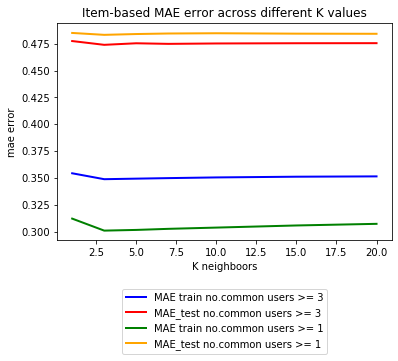

In [40]:
lw =2
import matplotlib.pyplot as plt
%matplotlib inline
K = [1,3,5,7,10,15,20]
mae_limit5 = [mae1, mae3, mae5, mae7, mae10, mae15, mae20]
mae_test_limit5 = [mae_1_test,mae_3_test, mae_5_test, mae_7_test, mae_10_test,mae_15_test,mae_20_test]
mae_limit1 = [mae1_T, mae3_T, mae5_T, mae7_T, mae10_T, mae15_T, mae20_T]
mae_test_limit1 = [mae_1_test_T,mae_3_test_T, mae_5_test_T, mae_7_test_T, mae_10_test_T,mae_15_test_T,mae_20_test_T]
plt.plot(K, mae_limit5, color = 'b',lw=lw, label = "MAE train no.common users >= 3")
plt.plot(K, mae_test_limit5, color = 'r',lw=lw, label = "MAE_test no.common users >= 3")
plt.plot(K, mae_limit1, color = 'green',lw=lw, label = "MAE train no.common users >= 1")
plt.plot(K, mae_test_limit1, color = 'orange',lw=lw, label = "MAE_test no.common users >= 1")
plt.xlabel("K neighboors")
plt.ylabel("mae error")
plt.title('Item-based MAE error across different K values')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))
plt.show()

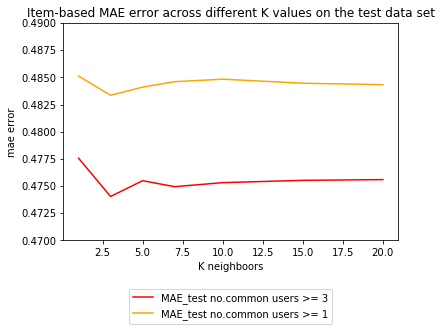

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
K = [1,3,5,7,10,15,20]
mae_test_limit3 = [mae_1_test,mae_3_test, mae_5_test, mae_7_test, mae_10_test,mae_15_test,mae_20_test]
mae_test_limit1 = [mae_1_test_T,mae_3_test_T, mae_5_test_T, mae_7_test_T, mae_10_test_T,mae_15_test_T,mae_20_test_T]
plt.plot(K, mae_test_limit3, color = 'r', label = "MAE_test no.common users >= 3")
plt.plot(K, mae_test_limit1, color = 'orange', label='MAE_test no.common users >= 1')
plt.xlabel("K neighboors")
plt.ylabel("mae error")
plt.title('Item-based MAE error across different K values on the test data set')
plt.ylim(0.47,0.49)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))
plt.show()

In [42]:
def commonS(k,neighboors):
    x = {}
    for i in song_users_test.keys():
        cj = 0
        for w,j in neighboors[i][0][0:k]:
            cj+=1
        x[i] = cj
    return x


Text(0.5, 1.0, 'Item-based CF: No of neighboors across users:common users >=1')

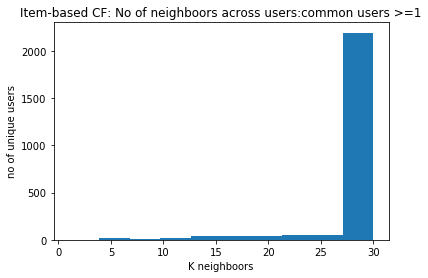

In [43]:
x = commonS(30,neighboors1)
plt.hist(x.values())
plt.xlabel("K neighboors")
plt.ylabel("no of unique users")
plt.title('Item-based CF: No of neighboors across users:common users >=1')

Text(0.5, 1.0, 'Item-based CF: No of neighboors across users:common users >=3')

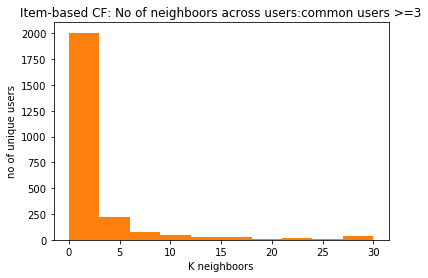

In [44]:
x = commonS(30,neighboors)
plt.hist(x.values())
plt.hist(x.values())
plt.xlabel("K neighboors")
plt.ylabel("no of unique users")
plt.title('Item-based CF: No of neighboors across users:common users >=3')